In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

In [47]:
df_cod = pd.read_csv('/content/drive/MyDrive/Hackathon/wfp_food_prices_cod.csv')
df_eth = pd.read_csv('/content/drive/MyDrive/Hackathon/wfp_food_prices_eth.csv')
df_ken = pd.read_csv('/content/drive/MyDrive/Hackathon/wfp_food_prices_ken.csv')
df_som = pd.read_csv('/content/drive/MyDrive/Hackathon/wfp_food_prices_som.csv')
df_sdn = pd.read_csv('/content/drive/MyDrive/Hackathon/wfp_food_prices_sdn.csv')
df_ssd = pd.read_csv('/content/drive/MyDrive/Hackathon/wfp_food_prices_ssd.csv')

def preprocess_data(df, commodity):
    df = df.drop(0)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    if commodity == 'overall':
        df_commodity = df.groupby('date')['price'].sum().reset_index()
    else:
        df_commodity = df[df['commodity'].str.lower().str.contains(commodity.lower())]
    df_commodity = df_commodity[['date', 'price']]
    df_commodity = df_commodity.set_index('date')
    df_commodity = df_commodity.resample('D').mean()
    df_commodity = df_commodity.fillna(method='ffill')
    df_commodity = df_commodity.dropna()
    df_commodity = df_commodity.reset_index()
    df_commodity = df_commodity.set_index('date')
    df_commodity = df_commodity['price']
    return df_commodity

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

def train_model(data, time_step=100):
    data = data.values.reshape(-1, 1)
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    training_size = int(len(data) * 0.8)
    test_size = len(data) - training_size
    train_data, test_data = data[0:training_size, :], data[training_size:len(data), :]
    X_train, Y_train = create_dataset(train_data, time_step)
    X_test, Y_test = create_dataset(test_data, time_step)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='loss', patience=2)
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping])
    return model, scaler, time_step, X_train, X_test, data #test_data

def predict_prices_for_countries(df, commodity, country, days=30):
      df_op = preprocess_data(df, commodity)
      model_op, scaler_op, time_step_op, X_train, X_test, data = train_model(df_op, 5)

      train_predict = model_op.predict(X_train)
      test_predict = model_op.predict(X_test)
      train_predict = scaler_op.inverse_transform(train_predict)
      test_predict = scaler_op.inverse_transform(test_predict)
      look_back = time_step_op
      trainPredictPlot = np.empty_like(data)
      trainPredictPlot[:] = np.nan
      trainPredictPlot[look_back:len(train_predict) + look_back] = train_predict
      testPredictPlot = np.empty_like(data)
      testPredictPlot[:] = np.nan
      testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(data) - 1] = test_predict
      plt.figure(figsize=(10,6))
      plt.plot(scaler_op.inverse_transform(data))
      plt.plot(trainPredictPlot)
      plt.plot(testPredictPlot)
      if commodity == 'overall':
        plt.title('Price for all Commodities in '+country)
      else:
        plt.title(commodity+' price in '+ country)
      plt.show()

Epoch 1/100
73/73 [==============================] - 8s 28ms/step - loss: 0.0060 - val_loss: 0.0065
Epoch 2/100
73/73 [==============================] - 1s 11ms/step - loss: 4.5361e-04 - val_loss: 0.0046
Epoch 3/100
73/73 [==============================] - 1s 11ms/step - loss: 4.1834e-04 - val_loss: 0.0039
Epoch 4/100
73/73 [==============================] - 1s 8ms/step - loss: 3.6174e-04 - val_loss: 0.0039
Epoch 5/100
73/73 [==============================] - 1s 8ms/step - loss: 3.8126e-04 - val_loss: 0.0039
Epoch 6/100
73/73 [==============================] - 1s 8ms/step - loss: 3.5408e-04 - val_loss: 0.0039
Epoch 7/100
73/73 [==============================] - 1s 8ms/step - loss: 3.4536e-04 - val_loss: 0.0043
Epoch 8/100
73/73 [==============================] - 1s 8ms/step - loss: 3.2234e-04 - val_loss: 0.0047
Epoch 9/100
73/73 [==============================] - 1s 8ms/step - loss: 3.2045e-04 - val_loss: 0.0043
Epoch 10/100
73/73 [==============================] - 1s 12ms/step - loss:

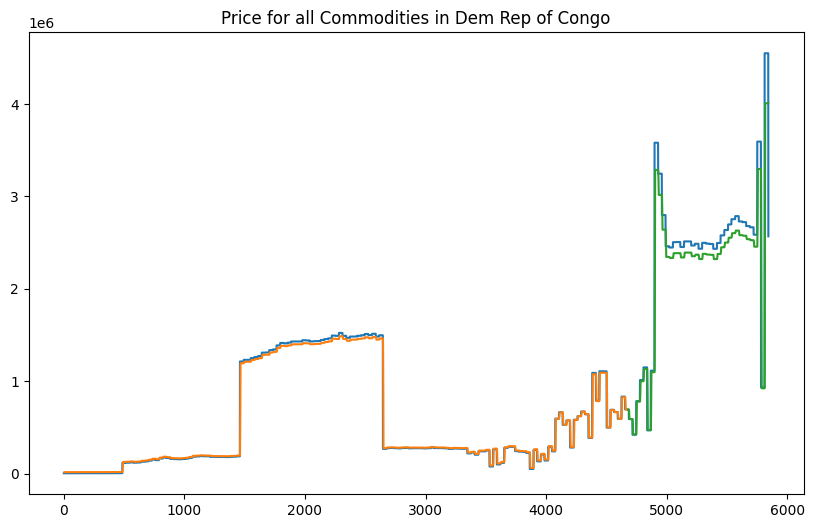

Epoch 1/100
111/111 [==============================] - 7s 19ms/step - loss: 5.3502e-04 - val_loss: 4.9824e-04
Epoch 2/100
111/111 [==============================] - 1s 8ms/step - loss: 4.7899e-05 - val_loss: 9.6378e-04
Epoch 3/100
111/111 [==============================] - 1s 8ms/step - loss: 4.9496e-05 - val_loss: 4.5733e-04
Epoch 4/100
111/111 [==============================] - 1s 8ms/step - loss: 4.3246e-05 - val_loss: 3.7167e-04
Epoch 5/100
111/111 [==============================] - 1s 8ms/step - loss: 4.1524e-05 - val_loss: 0.0020
Epoch 6/100
111/111 [==============================] - 1s 8ms/step - loss: 4.0266e-05 - val_loss: 0.0026
Epoch 7/100
111/111 [==============================] - 1s 8ms/step - loss: 3.7862e-05 - val_loss: 0.0014
Epoch 8/100
111/111 [==============================] - 1s 8ms/step - loss: 3.6381e-05 - val_loss: 0.0049
Epoch 9/100
111/111 [==============================] - 1s 8ms/step - loss: 3.7702e-05 - val_loss: 0.0036
Epoch 10/100
111/111 [================

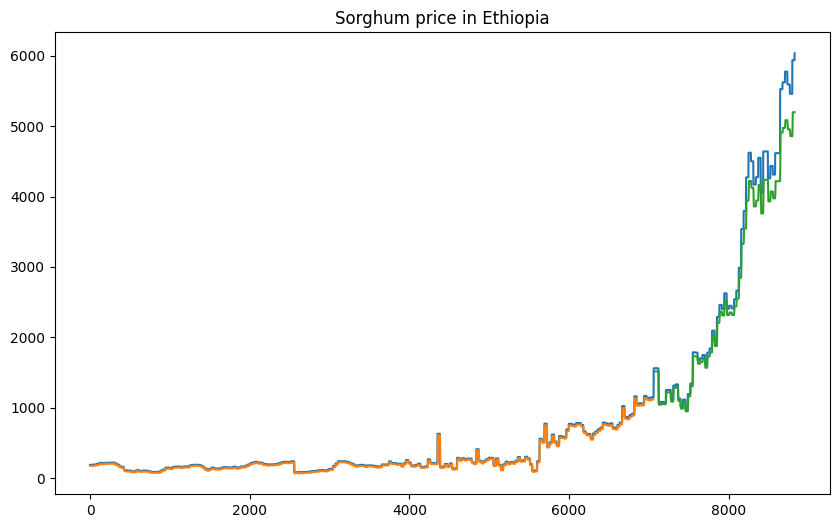

Epoch 1/100
83/83 [==============================] - 6s 20ms/step - loss: 0.0057 - val_loss: 0.0090
Epoch 2/100
83/83 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 3/100
83/83 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 4/100
83/83 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 5/100
83/83 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 6/100
83/83 [==============================] - 1s 11ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 7/100
83/83 [==============================] - 1s 8ms/step - loss: 0.0010 - val_loss: 0.0032
Epoch 8/100
83/83 [==============================] - 1s 8ms/step - loss: 9.0796e-04 - val_loss: 0.0024
Epoch 9/100
83/83 [==============================] - 1s 8ms/step - loss: 8.4863e-04 - val_loss: 0.0026
Epoch 10/100
83/83 [==============================] - 1s 8ms/step - loss: 7.8648e-04 - val_loss: 

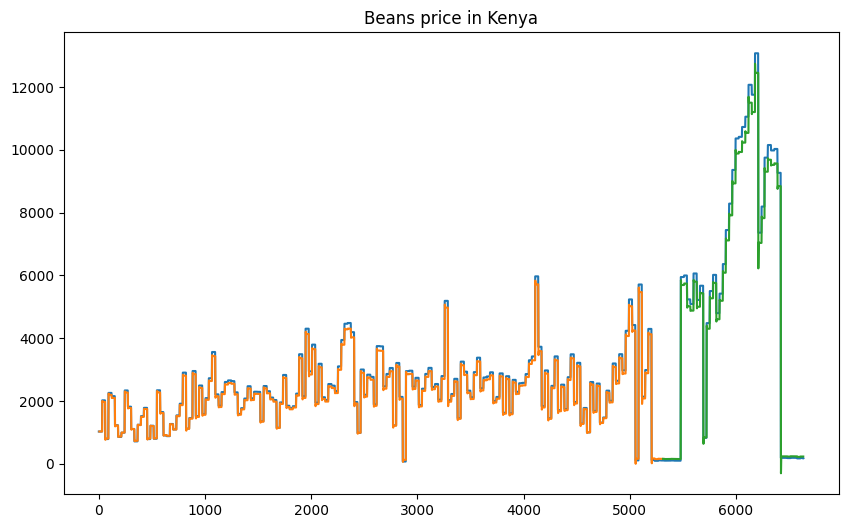

Epoch 1/100
131/131 [==============================] - 7s 15ms/step - loss: 0.0064 - val_loss: 4.9183e-04
Epoch 2/100
131/131 [==============================] - 1s 11ms/step - loss: 7.9926e-04 - val_loss: 0.0014
Epoch 3/100
131/131 [==============================] - 1s 11ms/step - loss: 6.8726e-04 - val_loss: 0.0018
Epoch 4/100
131/131 [==============================] - 1s 10ms/step - loss: 6.3815e-04 - val_loss: 4.2364e-04
Epoch 5/100
131/131 [==============================] - 1s 8ms/step - loss: 6.0890e-04 - val_loss: 0.0026
Epoch 6/100
131/131 [==============================] - 1s 8ms/step - loss: 5.6215e-04 - val_loss: 6.8358e-04
Epoch 7/100
131/131 [==============================] - 1s 8ms/step - loss: 5.5579e-04 - val_loss: 8.1093e-04
Epoch 8/100
131/131 [==============================] - 1s 8ms/step - loss: 5.2696e-04 - val_loss: 0.0010
Epoch 9/100
131/131 [==============================] - 1s 8ms/step - loss: 5.2171e-04 - val_loss: 4.2532e-04
Epoch 10/100
131/131 [=============

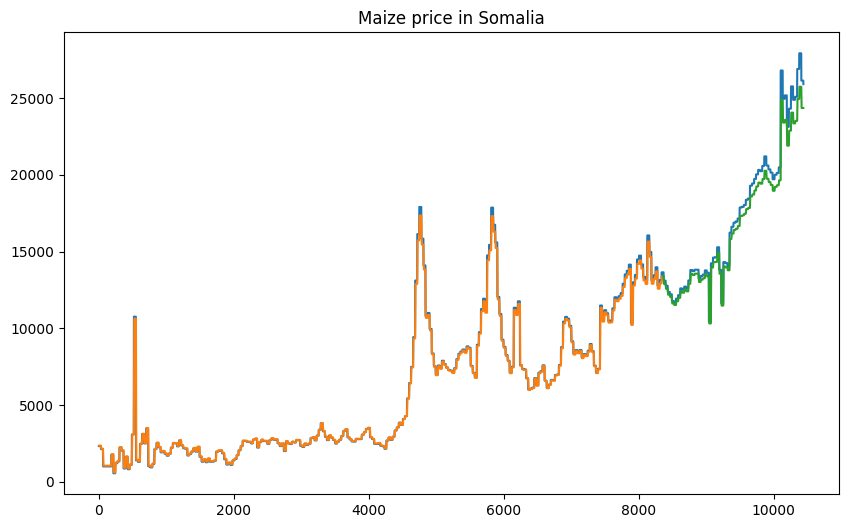

Epoch 1/100
106/106 [==============================] - 6s 17ms/step - loss: 4.9976e-05 - val_loss: 0.0029
Epoch 2/100
106/106 [==============================] - 1s 9ms/step - loss: 2.8795e-06 - val_loss: 0.0037
Epoch 3/100
106/106 [==============================] - 1s 8ms/step - loss: 3.2163e-06 - val_loss: 0.0029
Epoch 4/100
106/106 [==============================] - 1s 8ms/step - loss: 2.3980e-06 - val_loss: 0.0026
Epoch 5/100
106/106 [==============================] - 1s 8ms/step - loss: 2.5976e-06 - val_loss: 0.0026
Epoch 6/100
53/53 [==============================] - 0s 3ms/step


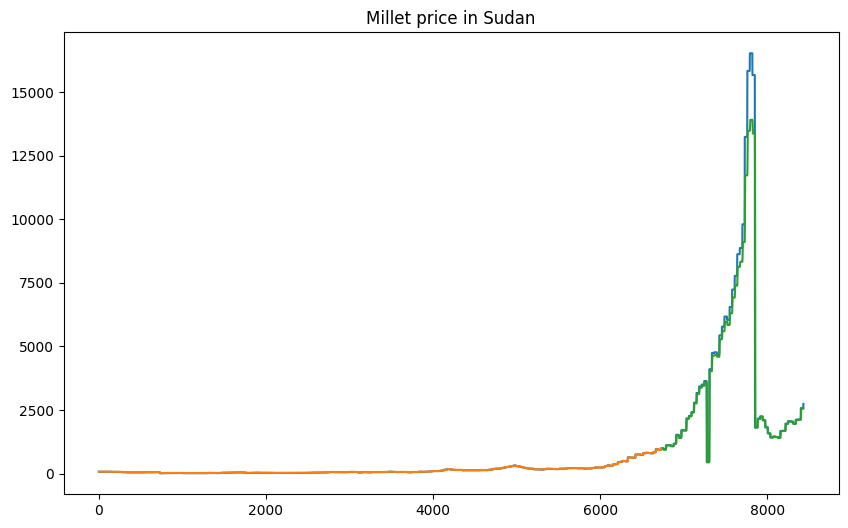

Epoch 1/100
70/70 [==============================] - 6s 22ms/step - loss: 1.8865e-05 - val_loss: 0.1165
Epoch 2/100
70/70 [==============================] - 1s 8ms/step - loss: 8.8381e-06 - val_loss: 0.0073
Epoch 3/100
70/70 [==============================] - 1s 10ms/step - loss: 7.1839e-07 - val_loss: 0.0025
Epoch 4/100
70/70 [==============================] - 1s 9ms/step - loss: 5.5558e-07 - val_loss: 0.0030
Epoch 5/100
70/70 [==============================] - 1s 8ms/step - loss: 4.1783e-07 - val_loss: 0.0028
Epoch 6/100
70/70 [==============================] - 1s 10ms/step - loss: 5.8107e-07 - val_loss: 0.0027
Epoch 7/100
35/35 [==============================] - 0s 3ms/step


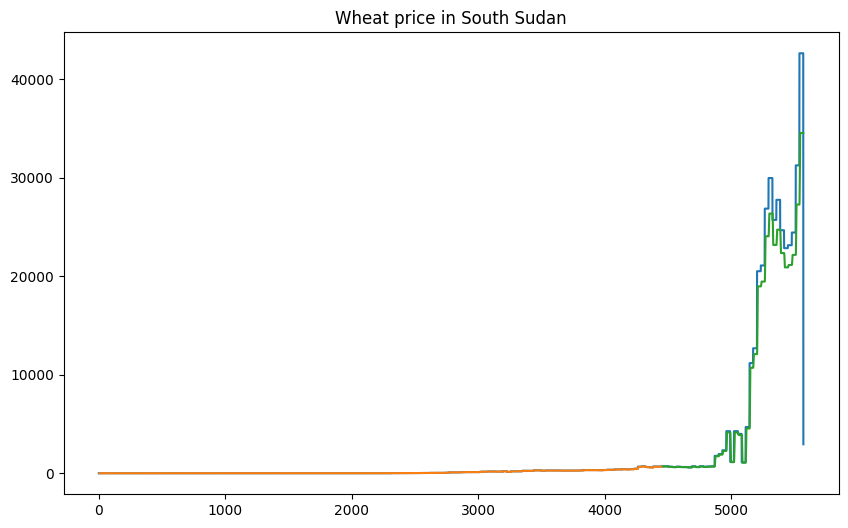

In [48]:
predict_prices_for_countries(df_cod, 'overall', 'Dem Rep of Congo')
predict_prices_for_countries(df_eth, 'Sorghum', 'Ethiopia')
predict_prices_for_countries(df_ken, 'Beans', 'Kenya')
predict_prices_for_countries(df_som, 'Maize', 'Somalia')
predict_prices_for_countries(df_sdn, 'Millet', 'Sudan')
predict_prices_for_countries(df_ssd, 'Wheat', 'South Sudan')